**DO NOT EDIT THIS FILE WITHIN THE /TSDS FOLDER - YOU RISK OVERWRITING YOUR WORK THE NEXT TIME YOU PULL FROM THE GITHUB REPOSITORY**

# Assignment 1


### Practical info
* Handin in absalon. The deadline is the 5th of march (see the [course plan](https://github.com/abjer/tsds/wiki/Course-plan))
* You must work in groups of 2-4. **Remember to identify the group members in the filename or in the top of the file contents**.
* If anything is unclear dont hesitate to email me at kuol@econ.ku.dk with questions.

<br>

<br>
<br>
<br>
<br>

# Questions from exercise set 1 (ML recap)
The following questions are drawn from exercise set 1. We have included code that allows you to solve the questions independently of the previous questions in exercise set 1. Note that you might have solved the questions in a different way than we anticipated. In this case the supplied code might need some modification to work with your answer. 

In [1]:
# Note: there are three .zip files with letter = a,b,c. 
# To ensure the files download in reasonable time we 
# only work with the first of the three. If you have time
# you can modify this cell to download all three. 

import os
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler        # scales variables to be mean=0,sd=1
from sklearn.linear_model import LogisticRegression     # regression model
from sklearn.pipeline import Pipeline                   # For building our model pipeline
from sklearn.model_selection import GridSearchCV



filenames = []
base_url = 'https://resources.lendingclub.com/'

letter = 'a'
filename = f'LoanStats3{letter}.csv.zip'
url = base_url+filename

if not os.path.exists(filename):
    r = requests.get(url, allow_redirects=True)
    open(filename, 'wb').write(r.content)
filenames.append(filename)

# Read in csv files, store them
dfs = [pd.read_csv(f,header=0,skiprows=1,low_memory=False) for f in filenames]

# concatenate the dataframes (as standard there is only 1)
df = pd.concat(dfs)\
        .dropna(subset=['loan_amnt'])\
        .dropna(axis=1, how='all')


# Identify loans of interest
df = df.loc[df.loan_status.isin(['Fully Paid', 'Charged Off'])].copy()

# Clean up variables 
df['charged_off'] = (df.loan_status=='Charged Off').astype(int)
df['int_rate_f'] = df.int_rate.str[:-1].astype(float)
df['emp_length_f'] = df.emp_length\
                        .str.split(' ')\
                        .str[0].str[:2]\
                        .str.replace('<','0')\
                        .astype(float)

# label and features
y_var = 'charged_off'
X_vars = ['term', 'int_rate_f', 'grade', 'home_ownership', 'emp_length_f',
          'annual_inc', 'verification_status', 'dti']

# Create dummies
data = pd.get_dummies(df[X_vars+[y_var]], drop_first=True)\
        .dropna()\
        .reset_index(drop=True)\
        .astype(np.float64)\
        .loc[:2000]\
        .copy()


sss = StratifiedShuffleSplit(n_splits=10, test_size=.3, random_state=3)

# These are the row indices of the stratified split
data_splits = list(sss.split(data[y_var], data[y_var]))

# Separate data in y,X
y = data[y_var]
X_vars_b = data.columns!=y_var
X = data.loc[:,X_vars_b]

train_idx, test_idx = data_splits[0]

y_train = y.loc[train_idx]
X_train = X.loc[train_idx]

y_test = y.loc[test_idx]
X_test = X.loc[test_idx]


# Fit vanilla linear model
lr = Pipeline([('scale', StandardScaler()),
               ('clf', LogisticRegression(class_weight='balanced',C=10**10, solver = 'liblinear'))])


lr.fit(X_train, y_train)


# Fit linear model with CV
lr_cv = GridSearchCV(estimator=lr,
                     param_grid={'clf__C':np.logspace(-4,4,5)},
                     n_jobs=-1,
                     cv=3)
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=10000000000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'clf__C': array([1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

> **Ex. 1.1.8:** Apply nested resampling to compute a distribution of test scores with and without optimization. You should use `data_splits` which we defined initially and input all the data.
>
>> *Hint:* You can implement this using your code from Ex. 1.1.6 and combine it with `cross_val_score`. Note that `cv` input should use `data_splits`. See Raschka pp. 188-189 for inspiration. 

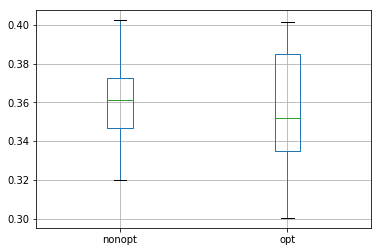

In [2]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer

# Set shared options 
options = dict(X = X, y = y, cv = data_splits, scoring = make_scorer(f1_score))

# Do cross validated scoring of both models
nonopt = cross_val_score(lr, **options)
opt    = cross_val_score(lr_cv, **options)

# Plot results
pd.DataFrame({'nonopt': nonopt, 'opt': opt}).boxplot()
plt.show()

>  **Ex. 1.1.11** Estimate a classification tree on the training data (with default hyperparameters). Evalate both on training and test data by computing the *area under the curve*.
>
>> *Hint:* You can check out code for Ex. 1.1.10 for inspiration. You may also want to look up `roc_auc_score`.

In [15]:
# [Answer to ex.1.1.11 here]
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

# Set up the model, and fit it to data
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

# Estimate AUC scores for train and test data
# Note roc_auc_score takes the actual values, 
# and a score, where "For binary y_true, y_score
# is supposed to be the score of the class with 
# greater label."
# E.g. the probability score for class 1, thus 
# the numpy slicing. 
trainscore = roc_auc_score(y_train, tree.predict_proba(X_train)[:,1])
testscore  = roc_auc_score(y_test, tree.predict_proba(X_test)[:,1])

# Print results
print("Train score:", trainscore)
print("Test score:", testscore)

Train score: 1.0
Test score: 0.5168564834083771


>  **Ex. 1.1.13** Is Random Forest classification different from the procedure of aggregating tree predictions above? If so, explain how.

In [21]:
# [Answer to ex.1.1.13 here]
# Skipped

<br>
<br>
<br>
<br>

# Questions from exercise set 2 (ANN 1)
The following questions are drawn from exercise set 2. We have included code that allows you to solve the questions independently of the previous questions in exercise set 1. Note that you might have solved the questions in a different way than we anticipated. In this case the supplied code might need some modification to work with your answer.

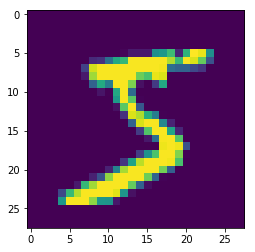

In [22]:
import numpy as np
import random
import matplotlib.pylab as plt
from scipy.interpolate import interp1d


# Miscellaneous functions
def sigmoid(z):
    """The sigmoid function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z) * (1 - sigmoid(z))

def step(z, threshold=0.5):
    if z > threshold:
        return 1
    return 0

# Feed forward neural network class
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        
        self.num_layers = len(sizes)
        self.sizes = sizes
        
        # Q: Print these out, explain their contents. You can instantiate a network by
        # doing `net = Network([2, 3, 1])`, and then printing `net.biases`.
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        
        # Q: What is `a`? How many iterations will this loop run? For a `sizes=[2, 3, 1]`
        # network, what is the shape of `a` at each iteration?
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None, silent=False):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        
        n = len(training_data)
        if test_data:
            n_test = len(test_data)
        
        for j in range(epochs):
            
            # Q: What happens here? Why do we shuffle the training data? Explain the
            # contents of `mini_batches`.
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)
            ]
            
            # Q: And what does this step do?
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            
            if not silent:
                if test_data:
                    print("Epoch {0}: {1} / {2}".format(j, self.evaluate(test_data), n_test))
                else:
                    print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        
        # Q: These two vectors correspond to -∇C(W) (and -∇C(b))
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # Q: But what happens here? Explain, in particular, how we update `nabla_b` and `nabla_w`
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        # Q: Now we have our gradient vectors, `nabla_b` and `nabla_w`. Explain how we use them
        # to update the weights and biases
        self.weights = [
            w - eta / len(mini_batch) * nw
            for w, nw in zip(self.weights, nabla_w)
        ]
        self.biases = [
            b - eta / len(mini_batch) * nb
            for b, nb in zip(self.biases, nabla_b)
        ]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book. Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on. It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return nabla_b, nabla_w

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        if self.sizes[-1] == 1:
            test_results = [
                (step(self.feedforward(x)), y)
                for x, y in test_data
            ]
        else:
            test_results = [
                (np.argmax(self.feedforward(x)), y)
                for x, y in test_data
            ]
        return sum(int(y_pred == y) for (y_pred, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return output_activations - y
    
    
# Load in the MNIST data used for ex. 2.2.x    
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()

plt.imshow(training_data[0][0].reshape(28, 28))
plt.show()

**Ex. 2.1.2** Using [the dataset](https://playground.tensorflow.org/#activation=sigmoid&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.16631&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false) with the hard-to-seperate circles, create the minimal neural network that seperates the clusters. Again, report your answer with a link.

In [ ]:
# [Answer to ex. 2.1.2]

**Ex. 2.2.4**: Now, fit a model with a suiting architecture (i.e. `sizes`) to `training_data`, and report your accuracy on the `validation_data`.

In [30]:
# [Answer to ex. 2.2.4]
net = Network([28*28, 50, 10])

net.SGD(training_data = training_data, 
        epochs = 10,
        mini_batch_size = 50,
        eta = 1,
        test_data = validation_data)

Epoch 0: 6983 / 10000
Epoch 1: 8098 / 10000
Epoch 2: 8646 / 10000
Epoch 3: 8840 / 10000
Epoch 4: 8932 / 10000
Epoch 5: 9020 / 10000
Epoch 6: 9084 / 10000
Epoch 7: 9123 / 10000
Epoch 8: 9153 / 10000
Epoch 9: 9187 / 10000


**Ex. 2.2.5**: Assuming you could get a "pretty" high accuracy in Ex. 2.2.4, Visualize 10 examples that get misclassified (remember to write what the correct label is). comment on what you see.

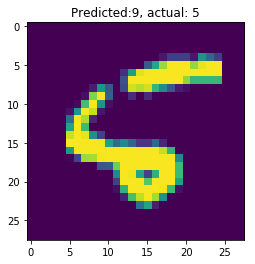

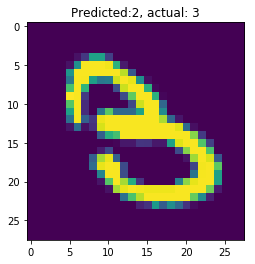

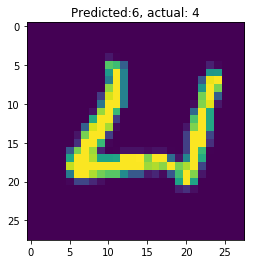

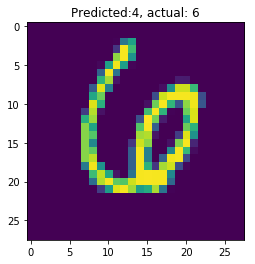

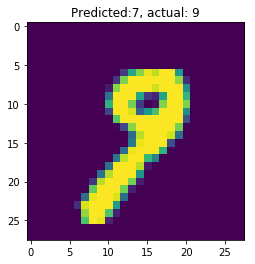

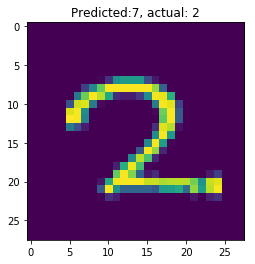

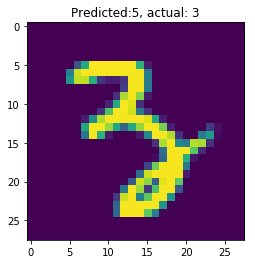

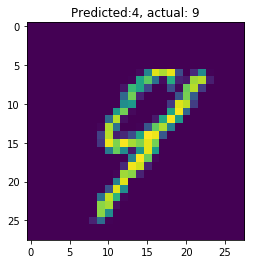

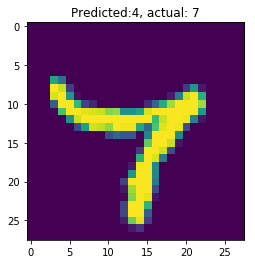

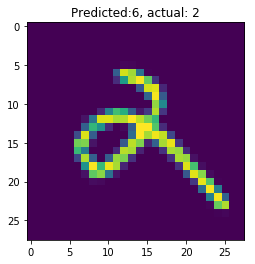

In [65]:
# [Answer to ex. 2.2.5]

# Run the trained network on the test data to get predictions
predictions = [(idx, np.argmax(net.feedforward(x)), y) for idx, (x, y) in enumerate(test_data)]


[
    (idx, pred, label),
    (idx, pred, label)
]

# Then take only the predictions which are wrong
misses = [im for im in predictions if im[1] != im[2]]

# And show the first 10 of these
for im in misses[:10]:
    idx, pred, label = im
    plt.imshow(test_data[idx][0].reshape(28, 28))
    plt.title(f"Predicted:{pred}, actual: {label}")
    plt.show()


<br>
<br>
<br>
<br>

# Questions from exercise set 3 (ANN 2)
The following questions are drawn from exercise set 3. 

![img](https://raw.githubusercontent.com/abjer/tsds/master/material_exercises/week_3/2_3_1_net.png)

**Ex. 3.1.2**: Knowing about backpropagation, we actually have everything we need here to compute the gradients of the weights by hand. So go ahead and do that. Report your answer either as a diagram that includes the gradients (you can draw on my figure somehow and insert the resulting image), or just by writing what the gradient of each weight is.
>
> *Hint: When computing gradients with backprop, it can be a bit easier to think of the network as a computational graph. My computational graph looks like [this](https://github.com/abjer/tsds/blob/master/material_exercises/week_3/2_3_1_net_compgraph.png?raw=true).*

In [ ]:
# [Answer to ex. 3.1.2]
# Skipped

<br>
<br>
<br>
<br>

# Questions from exercise set 4 (ANN 3)
The following questions are drawn from exercise set 4. Once again we provide you the code required to answer the question.


0 | loss: 839.1668090820312 | fraction correct: 0.0
10 | loss: 675.626953125 | fraction correct: 0.17
20 | loss: 706.736328125 | fraction correct: 0.18
30 | loss: 586.4313354492188 | fraction correct: 0.235
40 | loss: 553.9613647460938 | fraction correct: 0.255
50 | loss: 482.93896484375 | fraction correct: 0.3
60 | loss: 464.3443603515625 | fraction correct: 0.325
70 | loss: 493.38421630859375 | fraction correct: 0.33
80 | loss: 474.2262268066406 | fraction correct: 0.28
90 | loss: 464.35565185546875 | fraction correct: 0.375
100 | loss: 495.2441711425781 | fraction correct: 0.315
110 | loss: 489.931884765625 | fraction correct: 0.29
120 | loss: 450.211669921875 | fraction correct: 0.32
130 | loss: 422.3311767578125 | fraction correct: 0.44
140 | loss: 424.1958312988281 | fraction correct: 0.43
150 | loss: 424.65606689453125 | fraction correct: 0.44
160 | loss: 348.9714660644531 | fraction correct: 0.515
170 | loss: 421.2655334472656 | fraction correct: 0.37
180 | loss: 393.9519042968

1480 | loss: 336.3814697265625 | fraction correct: 0.47
1490 | loss: 398.91131591796875 | fraction correct: 0.405
1500 | loss: 386.43756103515625 | fraction correct: 0.465
1510 | loss: 387.7953186035156 | fraction correct: 0.42
1520 | loss: 235.53236389160156 | fraction correct: 0.685
1530 | loss: 367.2555236816406 | fraction correct: 0.465
1540 | loss: 273.0436706542969 | fraction correct: 0.57
1550 | loss: 245.3756561279297 | fraction correct: 0.64
1560 | loss: 342.4162292480469 | fraction correct: 0.46
1570 | loss: 385.5083312988281 | fraction correct: 0.46
1580 | loss: 348.9111633300781 | fraction correct: 0.435
1590 | loss: 345.08001708984375 | fraction correct: 0.495
1600 | loss: 261.502685546875 | fraction correct: 0.625
1610 | loss: 344.6087951660156 | fraction correct: 0.465
1620 | loss: 373.0887145996094 | fraction correct: 0.44
1630 | loss: 376.52227783203125 | fraction correct: 0.43
1640 | loss: 318.8835144042969 | fraction correct: 0.485
1650 | loss: 229.3841094970703 | fr

2940 | loss: 292.23504638671875 | fraction correct: 0.58
2950 | loss: 261.0482177734375 | fraction correct: 0.61
2960 | loss: 331.8600158691406 | fraction correct: 0.545
2970 | loss: 412.3061828613281 | fraction correct: 0.445
2980 | loss: 315.79437255859375 | fraction correct: 0.585
2990 | loss: 274.5959167480469 | fraction correct: 0.555
3000 | loss: 330.7440185546875 | fraction correct: 0.53
3010 | loss: 288.1031188964844 | fraction correct: 0.57
3020 | loss: 347.1191101074219 | fraction correct: 0.475
3030 | loss: 346.0267333984375 | fraction correct: 0.475
3040 | loss: 357.0374450683594 | fraction correct: 0.475
3050 | loss: 307.16363525390625 | fraction correct: 0.51
3060 | loss: 360.23681640625 | fraction correct: 0.405
3070 | loss: 275.2333984375 | fraction correct: 0.56
3080 | loss: 368.382080078125 | fraction correct: 0.455
3090 | loss: 317.4600830078125 | fraction correct: 0.525
3100 | loss: 319.7823486328125 | fraction correct: 0.51
3110 | loss: 309.941650390625 | fraction 

4390 | loss: 375.69989013671875 | fraction correct: 0.41
4400 | loss: 323.08758544921875 | fraction correct: 0.51
4410 | loss: 292.87664794921875 | fraction correct: 0.53
4420 | loss: 271.58392333984375 | fraction correct: 0.58
4430 | loss: 327.7568359375 | fraction correct: 0.485
4440 | loss: 302.8627624511719 | fraction correct: 0.515
4450 | loss: 281.42938232421875 | fraction correct: 0.545
4460 | loss: 328.0614318847656 | fraction correct: 0.505
4470 | loss: 324.7708435058594 | fraction correct: 0.52
4480 | loss: 299.159912109375 | fraction correct: 0.535
4490 | loss: 259.8730163574219 | fraction correct: 0.62
4500 | loss: 278.17694091796875 | fraction correct: 0.58
4510 | loss: 312.6706237792969 | fraction correct: 0.53
4520 | loss: 294.18292236328125 | fraction correct: 0.575
4530 | loss: 322.8442687988281 | fraction correct: 0.535
4540 | loss: 301.62945556640625 | fraction correct: 0.54
4550 | loss: 387.3337707519531 | fraction correct: 0.43
4560 | loss: 363.84979248046875 | fra

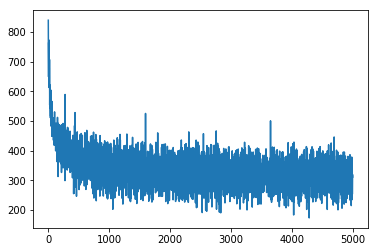

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import mnist_loader
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable

# Download the data (thanks MIT)
response = requests.get("http://shakespeare.mit.edu/hamlet/full.html")
hamlet = BeautifulSoup(response.content, "html.parser").getText()

# Convert text to character-level one-hot encoding
hamlet_one_hot = pd.get_dummies(pd.Series(list(hamlet)))
character_vec = hamlet_one_hot.columns
x = torch.from_numpy(hamlet_one_hot.values.astype(np.float32))


class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        
        # Parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        # Neural network layers. Rather than giving the input as a one-hot
        # vector, we represent it as a point in a high-dimensional space (i.e.
        # "an embedding"). This tends to work better.
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input_, hidden):
        signal = self.encoder(input_).view(1, 1, -1)  # Embed input character
        output, hidden = self.rnn(signal, hidden)     # Get output and hidden vector(s)
        prediction = self.decoder(output.view(1, -1))     # Decode to "prediction" vector
        
        return prediction, hidden

    def init_hidden(self):
        return (
            torch.autograd.Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
            torch.autograd.Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
        )
    
epochs = 5000
seq_len = 200
learning_rate = 1e-2
n_layers = 2

model = RNN(len(character_vec), 100, len(character_vec), n_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

# We're collecting the losses so we can plot how they (hopefully) decrease over time
all_losses = []
fraction_correct = []
for t in tqdm(range(epochs)):
    
    # Initiate a hidden vector for 
    hidden = model.init_hidden()
    
    # Pick a random input and output sequence. Here we are only taking one sequence
    # per epoch, but normally people take a batch of sequences. Check https://github
    # .com/spro/char-rnn.pytorch for an example on how to do that
    i = np.random.randint(0, x.size(0)-seq_len)
    input_ = torch.max(x[i:i+seq_len], 1)[1]      # torch.max(...)[1] gets the character in terms of its index, so
    target = torch.max(x[i+1:i+1+seq_len], 1)[1]  # input_ will be something like torch.tensor([2, 1, 4, 0, ... 1])
    
    # Backprop through time. Here we are just summing the losses from each timestep
    # and do backpropagation on the variable that holds the sum. PyTorch allows for that
    optimizer.zero_grad()
    loss = 0
    correct = 0
    for j in range(input_.size(0)):
        output, hidden = model(input_[j], hidden)
        loss += loss_fn(output.view(1, -1), target[j].view(1, ))
        correct += int(torch.max(output.view(1, -1), 1)[1][0] == target[j])
    
    # SGD step
    loss.backward()
    optimizer.step()
    
    # Collect loss value for plot
    all_losses.append(float(loss))
    fraction_correct.append(correct / input_.size(0))
        
    # Progress
    if t % 10 == 0:
        print(t, "| loss:", float(loss), "| fraction correct:", fraction_correct[-1])
    
    
plt.plot(all_losses)
plt.show()

> **Ex. 4.2.1**: Train the network for a while (the longer the better) until you feel its error has settled in some local minimum. Then go ahead and generate some gibberish Hamlet with it! To get better results, you can "warm up" the hidden state vectors by first running a sequence of actual Shapespeare through it and then starting generating from the last word in that sequence. Also, what I mean by "start generating" is that instead of predicting output from inputs drawn from your dataset, you input the prediction from the previous timestep and repeat, thus getting something that's completely made up.

In [106]:
# [Answer to ex. 4.2.1]
hidden = model.init_hidden()

for j in range(input_.size(0)):
    output, hidden = model(input_[j], hidden)

gibberish_hamlet = ""
for _ in range(1000):
    output, hidden = model(input_[2], hidden)
    gibberish_hamlet += character_vec[torch.max(output, 1)[1][0]]
    
print(gibberish_hamlet)


heeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee